# Dimensionality Reduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Projection methods

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA using SVD decomposition

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

# PCA using Scikit-Learn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [12]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [13]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio:

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Next, let's generate some nice figures! :)

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [23]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [24]:
def make_mesh(lims, h):
    x = np.linspace(lims[0], lims[1], h)
    y = np.linspace(lims[2], lims[3], h)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

In [25]:
lims = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1, x2 = make_mesh(lims, h=10)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

In [26]:
from mpl_toolkits.mplot3d import Axes3D

/var/folders/93/795zm8c93m16_92qkk86t0_r0000gn/T/ipykernel_59463/783479846.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]],


[(-1.8, 1.8), (-1.3, 1.3)]

/var/folders/93/795zm8c93m16_92qkk86t0_r0000gn/T/ipykernel_59463/145997561.py:8: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


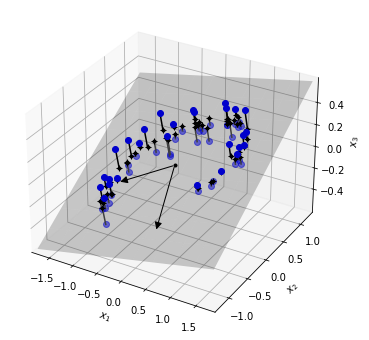

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

ax.add_artist(
    Arrow3D([0, C[0, 0]], [0, C[0, 1]], [0, C[0, 2]],
            mutation_scale=15,
            lw=1,
            arrowstyle="-|>",
            color="k"))
ax.add_artist(
    Arrow3D([0, C[1, 0]], [0, C[1, 1]], [0, C[1, 2]],
            mutation_scale=15,
            lw=1,
            arrowstyle="-|>",
            color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]],
                "k-",
                color="#505050")

ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set(xlabel="$x_1$", ylabel="$x_2$", zlabel="$x_3$")
ax.set(xlim=lims[0:2], ylim=lims[2:4])

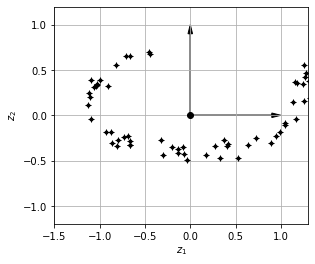

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0,
         0,
         0,
         1,
         head_width=0.05,
         length_includes_head=True,
         head_length=0.1,
         fc='k',
         ec='k')
ax.arrow(0,
         0,
         1,
         0,
         head_width=0.05,
         length_includes_head=True,
         head_length=0.1,
         fc='k',
         ec='k')
ax.set(xlabel="$z_1$", ylabel="$z_2$")
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

# Manifold learning

In [29]:
from sklearn.datasets import make_swiss_roll

In [30]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

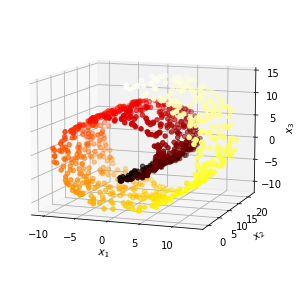

In [31]:
lims = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set(xlabel="$x_1$",
       ylabel="$x_2$",
       zlabel="$x_3$",
       xlim=lims[0:2],
       ylim=lims[2:4],
       zlim=lims[4:6])

plt.show()

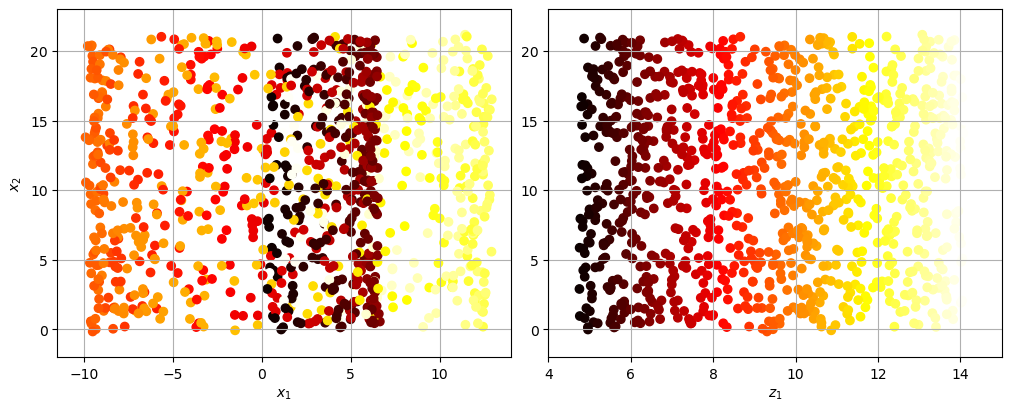

In [32]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, constrained_layout=True)

axes[0].scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
axes[0].axis(lims[:4])
axes[0].set(xlabel="$x_1$",ylabel="$x_2$")
axes[0].grid(1)

axes[1].scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
axes[1].axis([4, 15] + lims[2:4])
axes[1].set(xlabel="$z_1$")
axes[1].grid(1)

plt.show()

In [33]:
lims = [-11.5, 14, -2, 23, -12, 15]

x2, x3 = make_mesh(lims=lims[2:6], h=10)

In [34]:
from matplotlib import gridspec

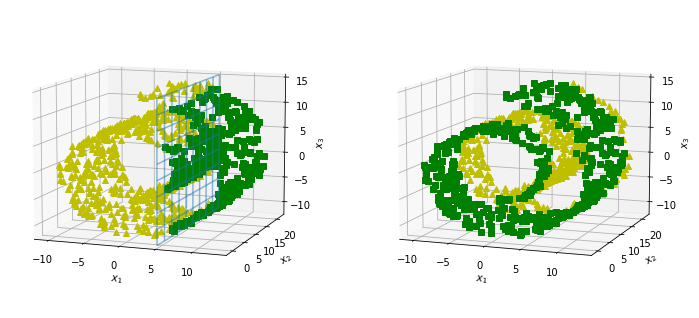

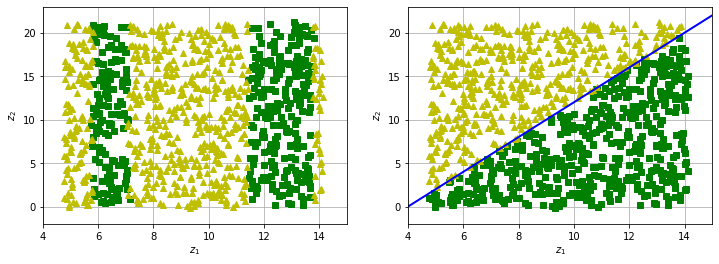

In [35]:
fig = plt.figure(figsize=(12, 8))

pos_classes = [X[:, 0] > 5, 2 * (t[:] - 4) > X[:, 1]]

for ind, positive_class in enumerate(pos_classes):

    ax = plt.subplot(121 + ind, projection='3d')
    X_pos = X[positive_class]
    X_neg = X[~positive_class]
    ax.view_init(10, -70)
    ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
    ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")

    if ind == 0:
        ax.plot_wireframe(5, x2, x3, alpha=0.5)

    ax.set(xlabel="$x_1$",
           ylabel="$x_2$",
           zlabel="$x_3$",
           xlim=lims[0:2],
           ylim=lims[2:4],
           zlim=lims[4:6])

plt.show()

fig = plt.figure(figsize=(12, 4))

for ind, positive_class in enumerate(pos_classes):
    ax = plt.subplot(121 + ind)
    ax.plot(t[positive_class], X[positive_class, 1], "gs")
    ax.plot(t[~positive_class], X[~positive_class, 1], "y^")
    ax.set(xlabel="$z_1$", ylabel="$z_2$")
    ax.axis([4, 15] + lims[2:4])
    ax.grid(1)
    if ind == 1:
        ax.plot([4, 15], [0, 22], "b-", lw=2)

plt.show()


# PCA

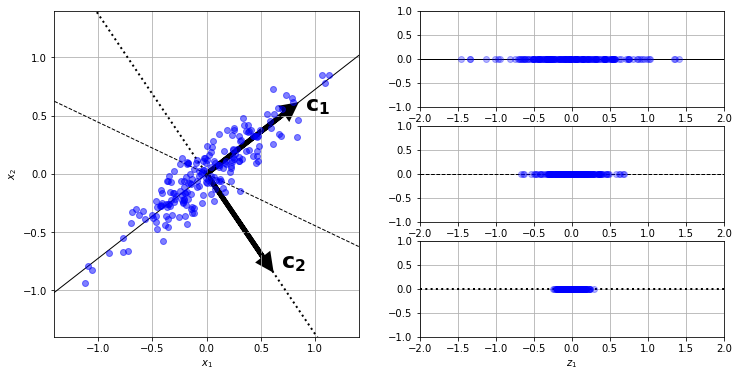

In [36]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]]))  # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle),
                                            np.cos(angle)]])  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(12, 6))
ax = plt.subplot2grid((3, 2), (0, 0), rowspan=3)

ax.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", lw=1)
ax.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", lw=1)
ax.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", lw=2)
ax.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
ax.axis([-1.4, 1.4, -1.4, 1.4])

arrow_prop = {
    'head_width': 0.1,
    'lw': 5,
    'length_includes_head': True,
    'head_length': 0.1,
    'fc': 'k',
    'ec': 'k'
}

ax.arrow(0, 0, u1[0], u1[1], **arrow_prop)
ax.arrow(0, 0, u3[0], u3[1], **arrow_prop)
ax.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
ax.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
ax.set(xlabel="$x_1$", ylabel="$x_2$")
ax.grid(1)

ax = plt.subplot2grid((3, 2), (0, 1))
ax.plot([-2, 2], [0, 0], "k-", lw=1)
ax.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
ax.axis([-2, 2, -1, 1])
ax.grid(1)

ax = plt.subplot2grid((3, 2), (1, 1))
ax.plot([-2, 2], [0, 0], "k--", lw=1)
ax.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
ax.axis([-2, 2, -1, 1])
ax.grid(1)

ax = plt.subplot2grid((3, 2), (2, 1))
ax.plot([-2, 2], [0, 0], "k:", lw=2)
ax.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
ax.axis([-2, 2, -1, 1])
ax.set(xlabel="$z_1$")
ax.grid(1)

plt.show()

## MNIST compression

In [37]:
from sklearn.datasets import fetch_openml

In [38]:
# X, y = fetch_openml('mnist_784',
#                     version=1,
#                     as_frame=True,
#                     return_X_y=True,
#                     data_home='data')
# y = y.astype(np.int8)
# X.to_feather('data/mnist_784_X.feather')
# y.to_frame().to_feather('data/mnist_784_y.feather')
X = pd.read_feather('data/mnist_784_X.feather')
y = pd.read_feather('data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

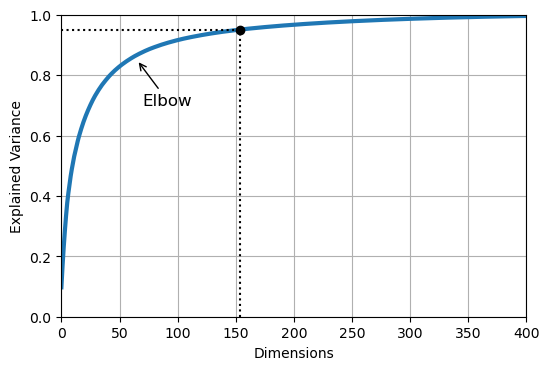

In [41]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.axis([0, 400, 0, 1])
ax.set(xlabel="Dimensions", ylabel="Explained Variance")
ax.plot(cumsum, lw=3)
ax.plot([d, d], [0, 0.95], "k:")
ax.plot([0, d], [0.95, 0.95], "k:")
ax.plot(d, 0.95, "ko")
ax.annotate("Elbow",
            xy=(65, 0.85),
            xytext=(70, 0.7),
            arrowprops=dict(arrowstyle="->"),
            fontsize='large')
ax.grid(1)

plt.show()

In [42]:
X_reduced = pca.fit_transform(X_train)

In [43]:
pca.n_components_

784

In [44]:
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [45]:
import matplotlib as mpl

In [46]:
def plot_digit(ax, data):
    image = data.reshape(28, 28)
    ax.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    ax.axis("off")

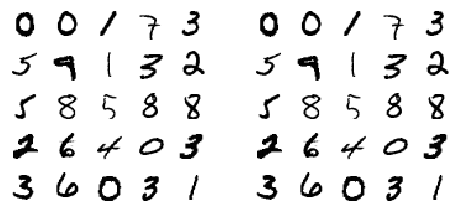

In [47]:
fig = plt.figure(figsize=(8, 8))
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.2)

out_grids = [(0, 0), (0, 1)]
titles = ["Original", "Compressed"]

for X_subset, (a, b), title in zip([X_train, X_recovered], out_grids, titles):
    inner_grid = outer_grid[a, b].subgridspec(5, 5)
    axes = inner_grid.subplots()

    X_c = X_subset[::2100]

    for ind, ax in enumerate(axes.flatten()):
        plot_digit(ax, X_c[ind, :])

plt.show()

In [48]:
X_reduced_pca = X_reduced

## Incremental PCA

In [49]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [50]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

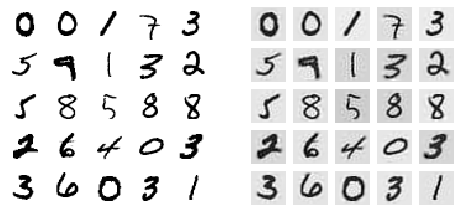

In [51]:
fig = plt.figure(figsize=(8, 8))
outer_grid = fig.add_gridspec(2, 2, wspace=0.2, hspace=0.2)

out_grids = [(0, 0), (0, 1)]
titles = ["Original", "Compressed"]

for X_subset, (a, b), title in zip([X_train, X_recovered_inc_pca], out_grids,
                                   titles):
    inner_grid = outer_grid[a, b].subgridspec(5, 5)
    axes = inner_grid.subplots()

    X_c = X_subset[::2100]

    for ind, ax in enumerate(axes.flatten()):
        plot_digit(ax, X_c[ind, :])

plt.show()

In [52]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [53]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [54]:
# np.allclose(X_reduced_pca, X_reduced_inc_pca)

### Using `memmap()`

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [55]:
# m, n = X_train.shape

# X_mm = np.memmap("data/my_mnist.data", dtype='float32', mode='write', shape=(m, n))
# X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [56]:
# del X_mm

Next, another program would load the data and use it for training:

In [57]:
# X_mm = np.memmap("data/my_mnist.data",
#                  dtype="float32",
#                  mode="readonly",
#                  shape=(m, n))

# batch_size = m // n_batches
# inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
# inc_pca.fit(X_mm)

In [58]:
# rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
# X_reduced = rnd_pca.fit_transform(X_train)

## Time complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [59]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components,
                  random_state=42,
                  svd_solver="randomized")
    names = ["PCA", "Inc PCA", "Rnd PCA"]
    pcas = [regular_pca, inc_pca, rnd_pca]

    for name, pca in zip(names, pcas):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print(f"{name}: {t2 - t1:.1f} seconds")

n_components = 2
PCA: 21.4 seconds
Inc PCA: 42.9 seconds
Rnd PCA: 2.9 seconds
n_components = 10
PCA: 20.8 seconds
Inc PCA: 78.9 seconds
Rnd PCA: 5.1 seconds
n_components = 154
PCA: 15.3 seconds
Inc PCA: 166.8 seconds
Rnd PCA: 22.8 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

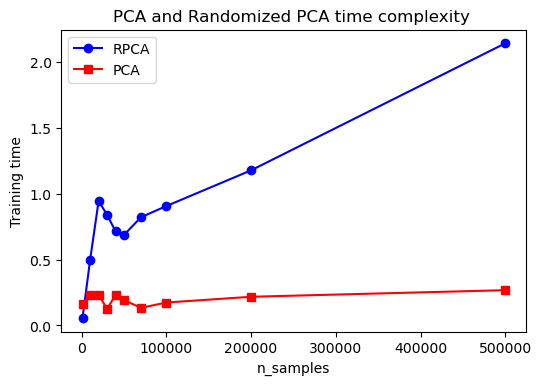

In [60]:
times_rpca = []
times_pca = []
sizes = [
    1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000
]

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)


ax.plot(sizes, times_rpca, "b-o", label="RPCA")
ax.plot(sizes, times_pca, "r-s", label="PCA")
ax.set(xlabel="n_samples",
       ylabel="Training time",
       title="PCA and Randomized PCA time complexity ")
ax.legend(loc="upper left")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

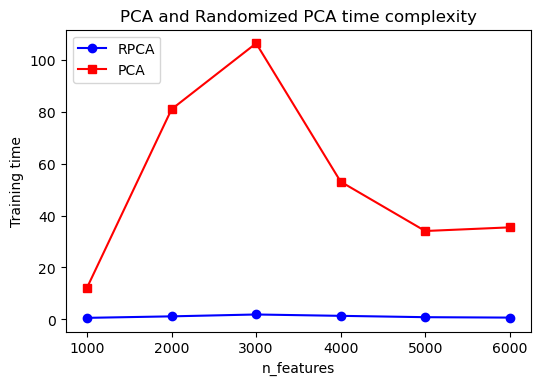

In [61]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]

for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(sizes, times_rpca, "b-o", label="RPCA")
ax.plot(sizes, times_pca, "r-s", label="PCA")
ax.set(xlabel="n_features",
       ylabel="Training time",
       title="PCA and Randomized PCA time complexity")
ax.legend(loc="upper left")
plt.show()

## Kernel PCA

In [62]:
from sklearn.decomposition import KernelPCA

In [63]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [64]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

In [65]:
lin_pca = KernelPCA(n_components=2,
                    kernel="linear",
                    fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2,
                    kernel="rbf",
                    gamma=0.0433,
                    fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2,
                    kernel="sigmoid",
                    gamma=0.001,
                    coef0=1,
                    fit_inverse_transform=True)


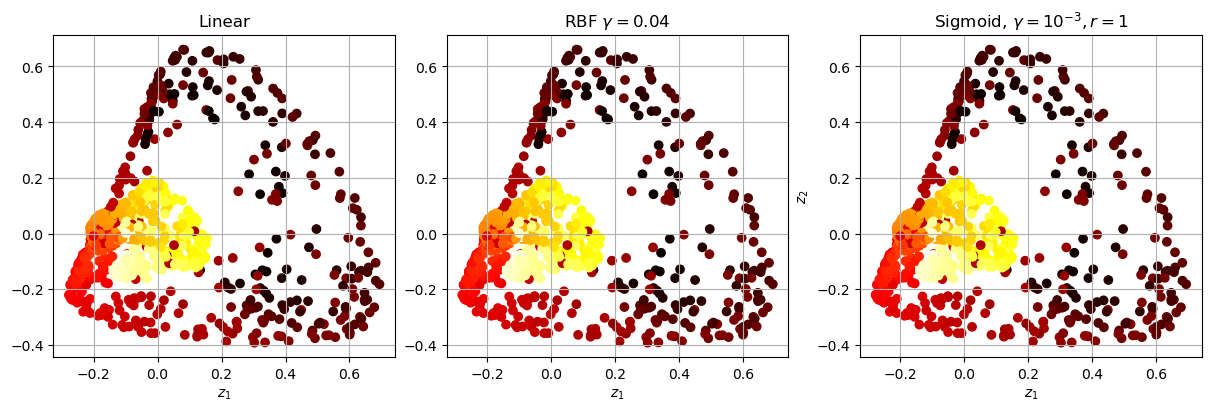

In [66]:
y = t > 6.9

_, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100, constrained_layout=True)

titles = ["Linear", "RBF $γ=0.04$", "Sigmoid, $γ=10^{-3}, r=1$"]
pcas = [lin_pca, rbf_pca, sig_pca]

for title, pca, ax in zip(titles, pcas, axes.flatten()):
    ax.annotate("Elbow",
                xy=(65, 0.85),
                xytext=(70, 0.7),
                arrowprops=dict(arrowstyle="->"),
                fontsize='large')
    X_reduced_rbf = X_reduced

    #ax.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #ax.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    ax.set(xlabel="$z_1$", title=title)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
        
    ax.grid(1)

axes[2].set(ylabel="$z_2$")
plt.show()

In [67]:
# plt.figure(figsize=(6, 5))

# X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

# ax = plt.subplot(111, projection='3d')
# ax.view_init(10, -70)
# ax.scatter(X_inverse[:, 0],
#            X_inverse[:, 1],
#            X_inverse[:, 2],
#            c=t,
#            cmap=plt.cm.hot,
#            marker="x")

# ax.set(xlabel="",
#        ylabel="",
#        zlabel="",
#        xticklabels=[],
#        yticklabels=[],
#        zticklabels=[])

# plt.show()

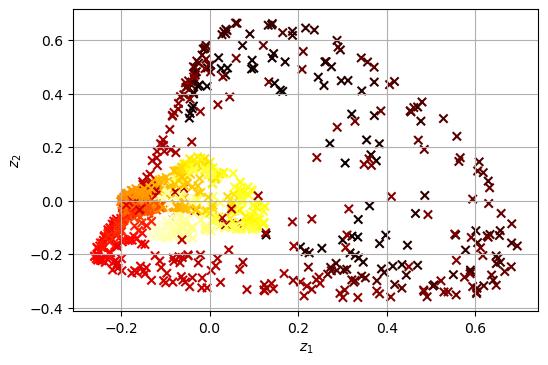

In [68]:
X_reduced = rbf_pca.fit_transform(X)

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
ax.set(xlabel="$z_1$", ylabel="$z_2$")
ax.grid(1)

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [70]:
clf = Pipeline([("kpca", KernelPCA(n_components=2)),
                ("log_reg", LogisticRegression(solver="lbfgs"))])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [71]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [72]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [73]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576617

# LLE

In [74]:
from sklearn.manifold import LocallyLinearEmbedding

In [75]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [76]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

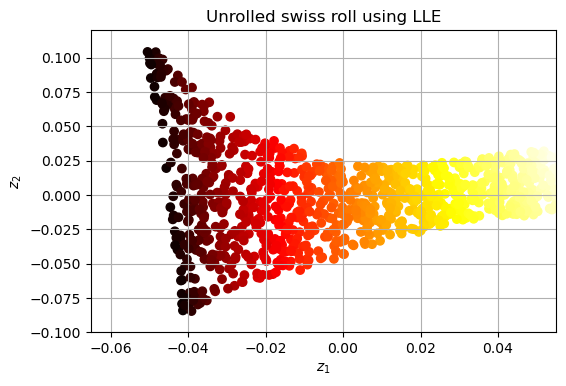

In [77]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
ax.set(xlabel="$z_1$", ylabel="$z_2$", title="Unrolled swiss roll using LLE")
ax.axis([-0.065, 0.055, -0.1, 0.12])
ax.grid(1)

plt.show()

# MDS, Isomap and t-SNE

In [78]:
from sklearn.manifold import MDS, Isomap, TSNE

In [79]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [82]:
X = pd.read_feather('data/mnist_784_X.feather')
y = pd.read_feather('data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [93]:
y = y.ravel()

In [94]:
lda = LinearDiscriminantAnalysis(n_components=2)

lda.fit(X, y)
X_reduced_lda = lda.transform(X)

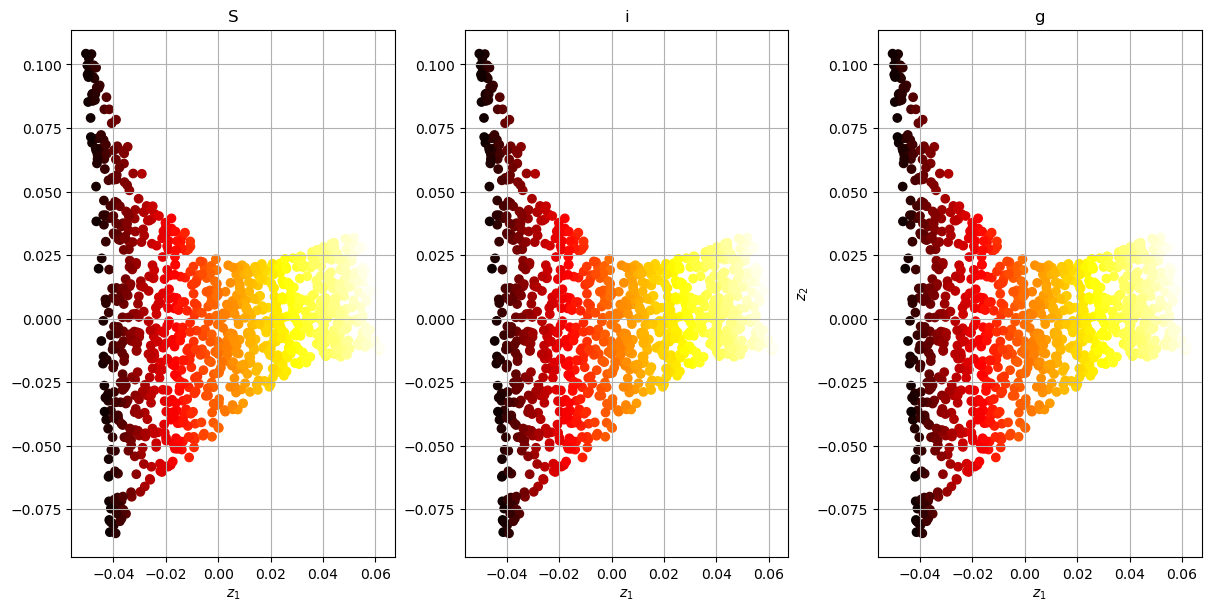

In [84]:
titles = ["MDS", "Isomap", "t-SNE"]

_, axes = plt.subplots(1, 3, figsize=(12, 6), dpi=100, constrained_layout=True)

X_reds = (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)

for X_red, title, ax in zip(X_reds, title, axes.flatten()):

    ax.set(xlabel="$z_1$", title=title)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
       
    ax.grid(1)

axes[2].set(ylabel="$z_2$")
plt.show()

# Exercise solutions

*Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).*

The MNIST dataset was loaded earlier.

In [85]:
X = pd.read_feather('data/mnist_784_X.feather')
y = pd.read_feather('data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [96]:
y = y.ravel()
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [118]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 76.77s


In [91]:
from sklearn.metrics import accuracy_score

In [119]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [99]:
from sklearn.decomposition import PCA

In [115]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [ ]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print(f"Training took {t1 - t0:.2f}s")

Training took 200.78s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

*Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [121]:
X_test_reduced = pca.transform(X_test)

# y_pred = rnd_clf2.predict(X_test_reduced)
# accuracy_score(y_test, y_pred)

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [105]:
from sklearn.linear_model import LogisticRegression

In [106]:
log_clf = LogisticRegression(multi_class="multinomial",
                             solver="lbfgs",
                             random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print(f"Training took {t1 - t0:.2f}s")

Training took 25.23s


/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [108]:
log_clf2 = LogisticRegression(multi_class="multinomial",
                              solver="lbfgs",
                              random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print(f"Training took {t1 - t0:.2f}s")

Training took 20.27s


/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nice! Reducing dimensionality led to over 2× speedup. :)  Let's check the model's accuracy:

In [122]:
# y_pred = log_clf2.predict(X_test_reduced)
# accuracy_score(y_test, y_pred)

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [110]:
X = pd.read_feather('data/mnist_784_X.feather')
y = pd.read_feather('data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()
y = y.ravel()

In [111]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = X[idx]
y = y[idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [112]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

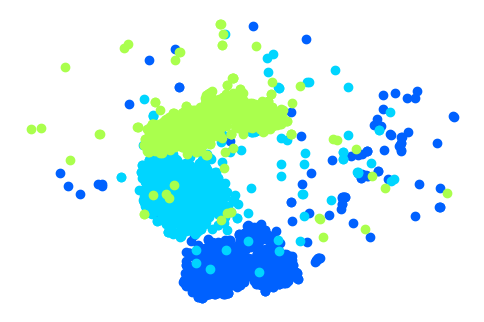

In [127]:
cmap = mpl.cm.get_cmap("jet")

_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for digit in (2, 3, 5):
    ax.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
ax.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [131]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2,
                   random_state=42,
                   init='pca',
                   learning_rate='auto')
X_subset_reduced = tsne_subset.fit_transform(X_subset)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


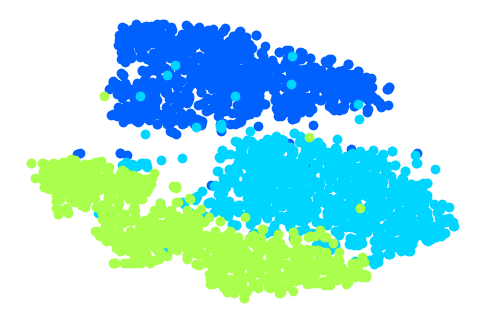

In [132]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for digit in (2, 3, 5):
    ax.scatter(X_subset_reduced[y_subset == digit, 0],
               X_subset_reduced[y_subset == digit, 1],
               c=[cmap(digit / 9)])
ax.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [133]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [134]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0],
                    X_normalized[y == digit, 1],
                    c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord,
                                          axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0],
                         image_coord[1],
                         str(int(y[index])),
                         color=cmap(y[index] / 9),
                         fontdict={
                             "weight": "bold",
                             "size": 16
                         })
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

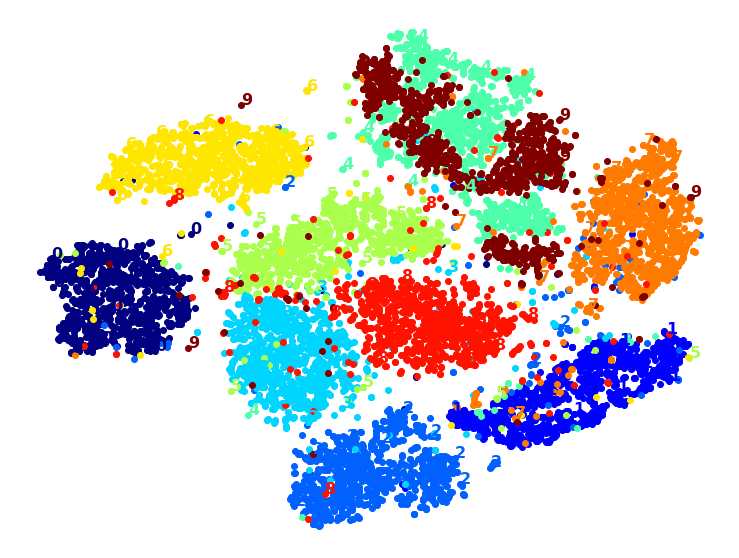

In [135]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

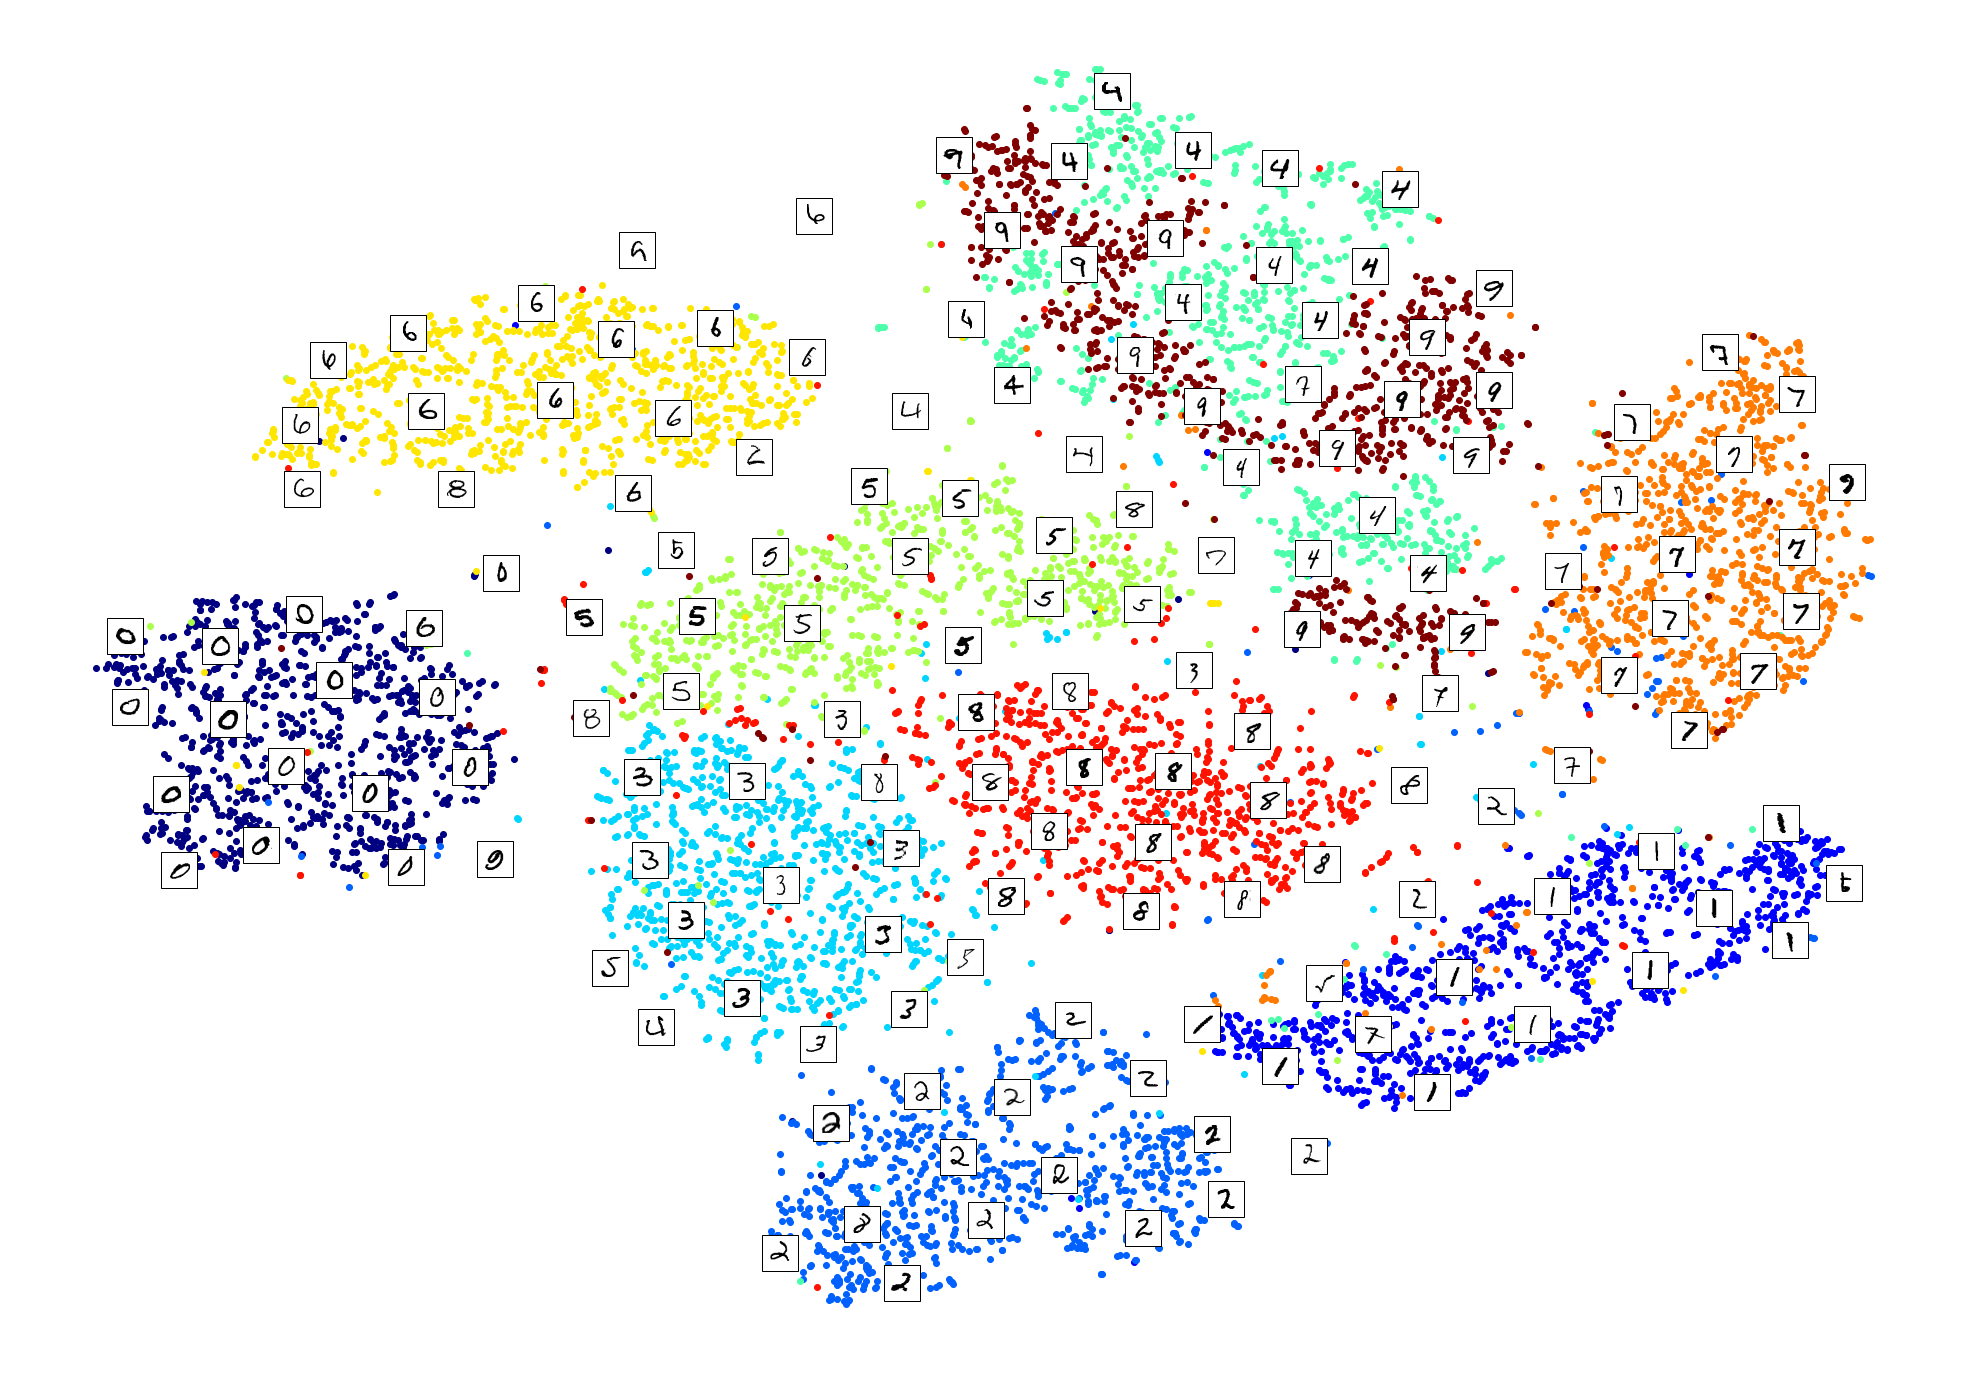

In [136]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

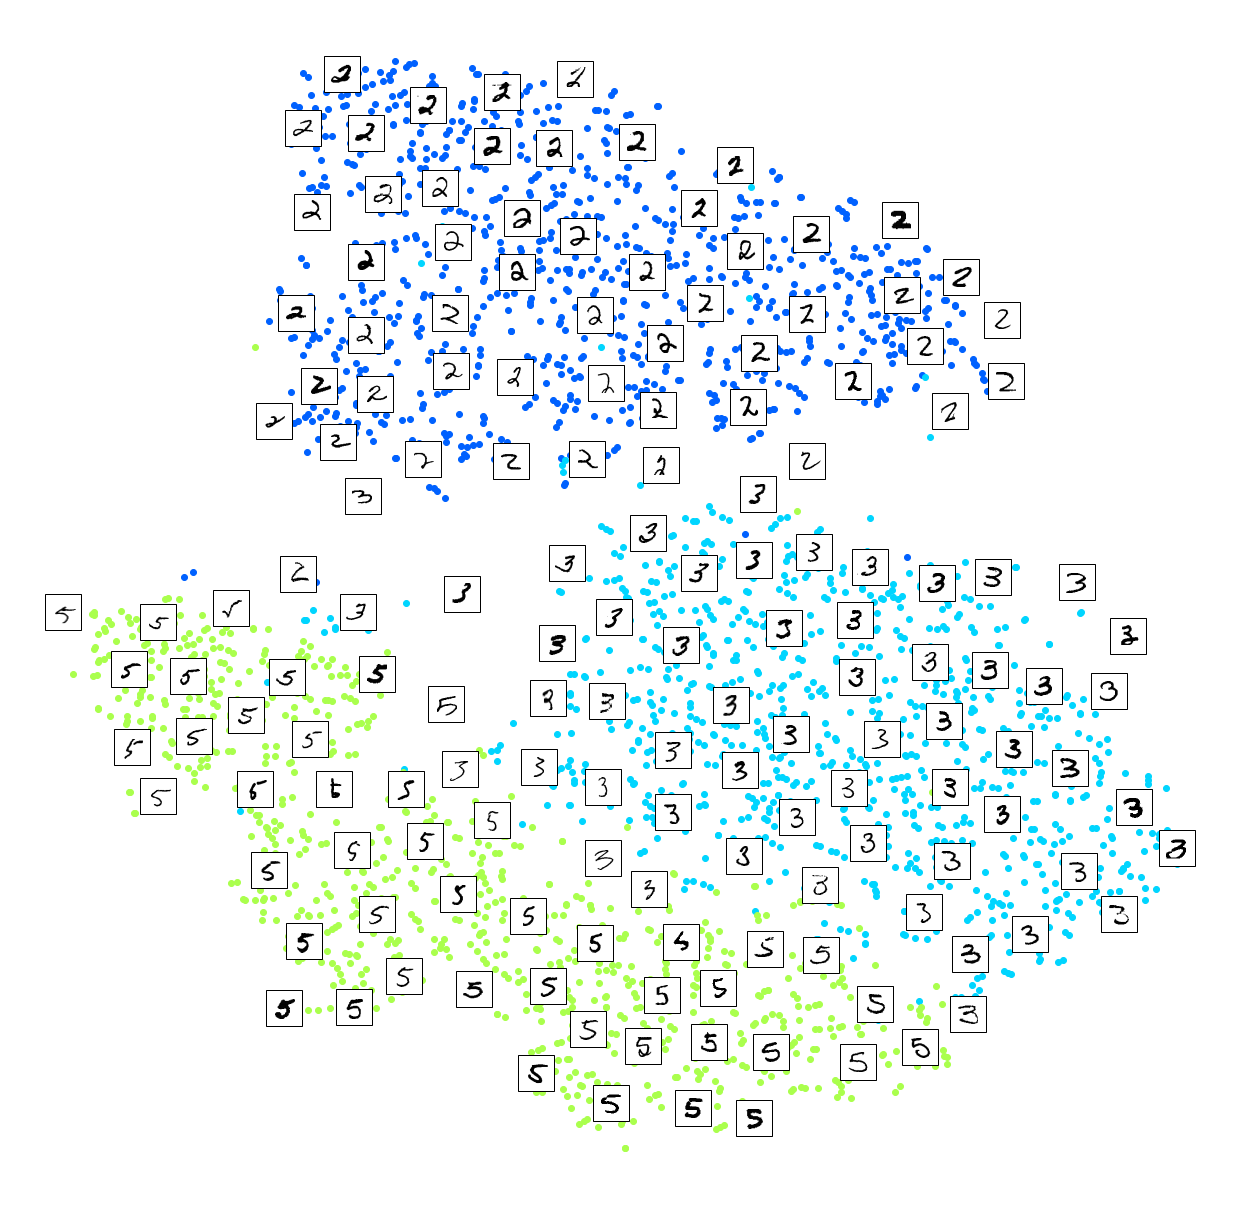

In [137]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

PCA took 2.0s.


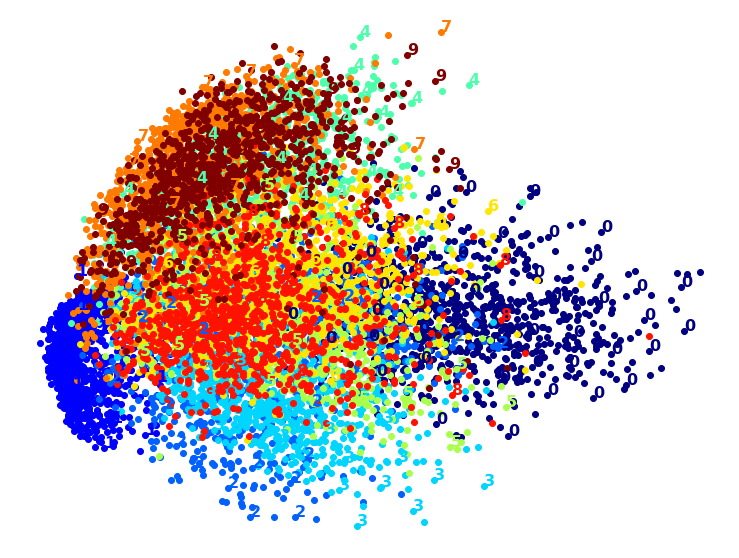

In [150]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 135.7s.


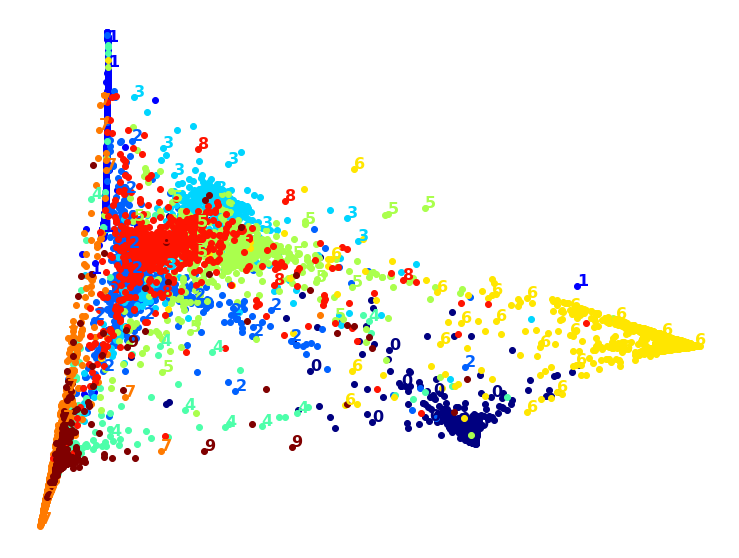

In [139]:
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2,
                                       random_state=42).fit_transform(X)
t1 = time.time()
print(f"LLE took {t1 - t0:.1f}s.")
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 155.3s.


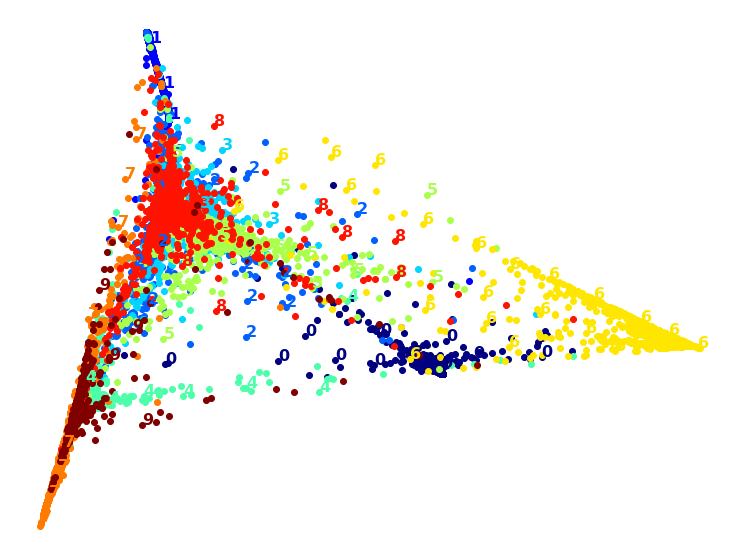

In [140]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print(f"PCA+LLE took {t1 - t0:.1f}s.")
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

In [141]:
from sklearn.manifold import MDS

MDS took 268.8s (on just 2,000 MNIST images instead of 10,000).


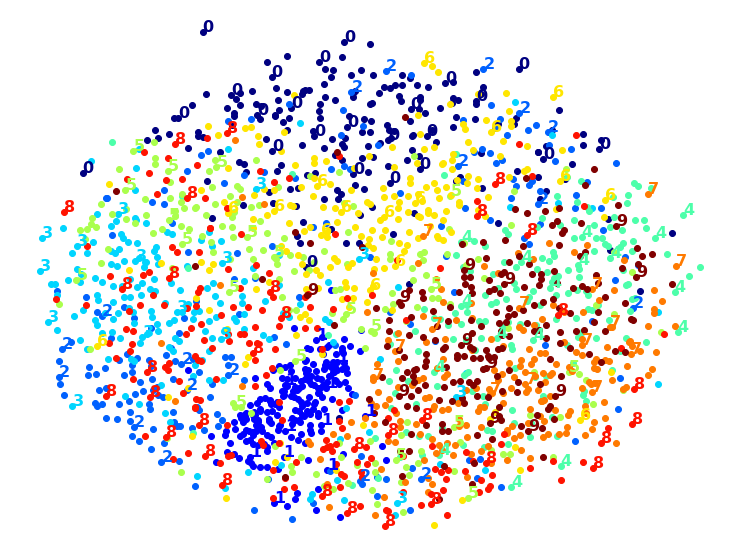

In [142]:
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print(
    f"MDS took {t1 - t0:.1f}s (on just 2,000 MNIST images instead of 10,000).")
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

PCA+MDS took 275.8s (on 2,000 MNIST images).


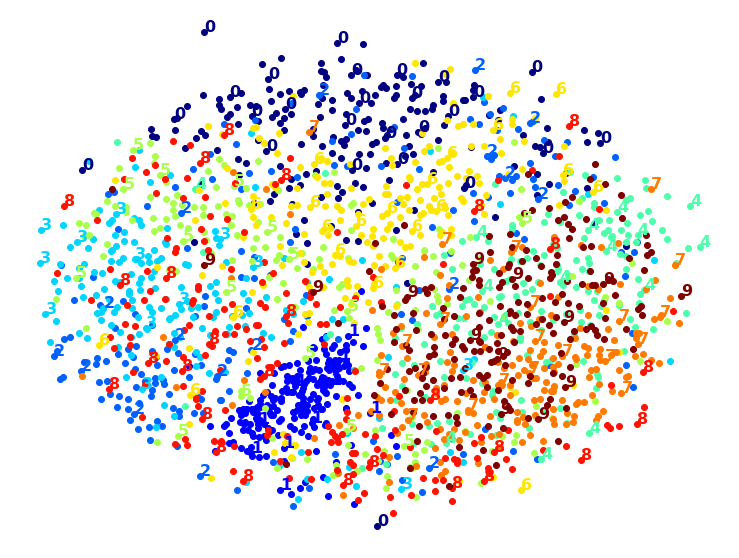

In [143]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print(f"PCA+MDS took {t1 - t0:.1f}s (on 2,000 MNIST images).")
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (nor hurt).

Let's try LDA:

In [144]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA took 14.6s.


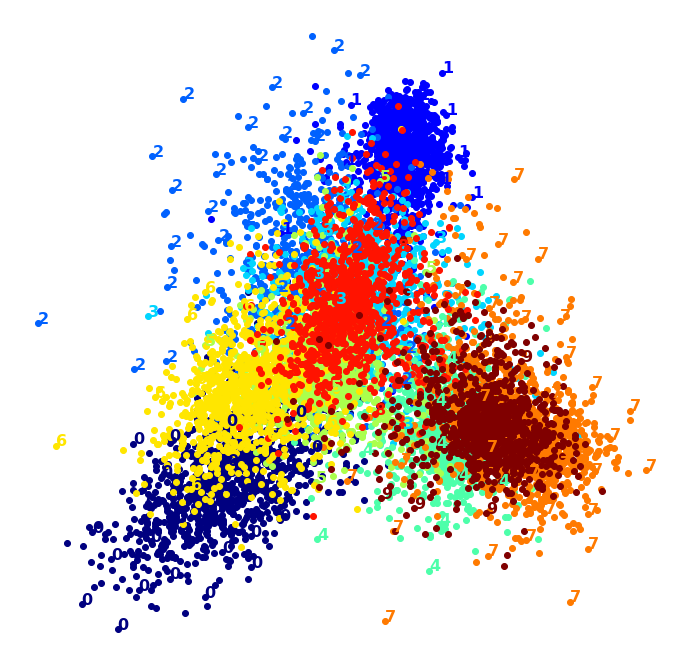

In [145]:
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print(f"LDA took {t1 - t0:.1f}s.")
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


t-SNE took 331.0s.


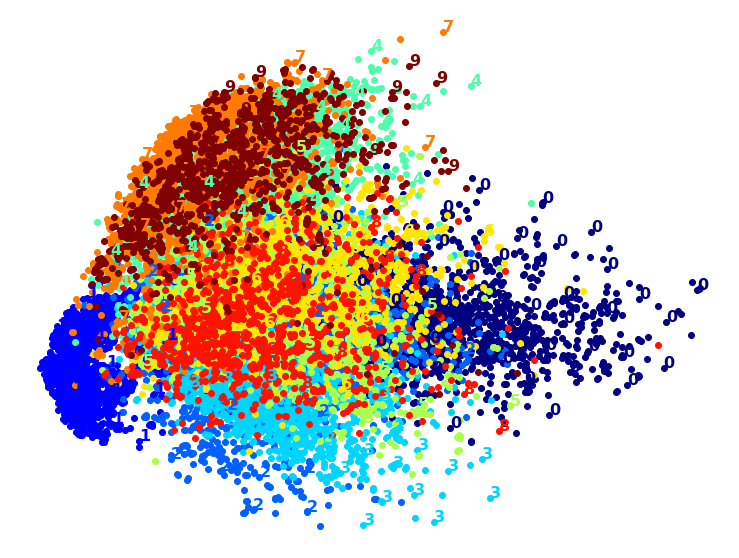

In [147]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2,
                      random_state=42,
                      init='pca',
                      learning_rate='auto').fit_transform(X)
t1 = time.time()
print(f"t-SNE took {t1 - t0:.1f}s.")
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


PCA+t-SNE took 200.6s.


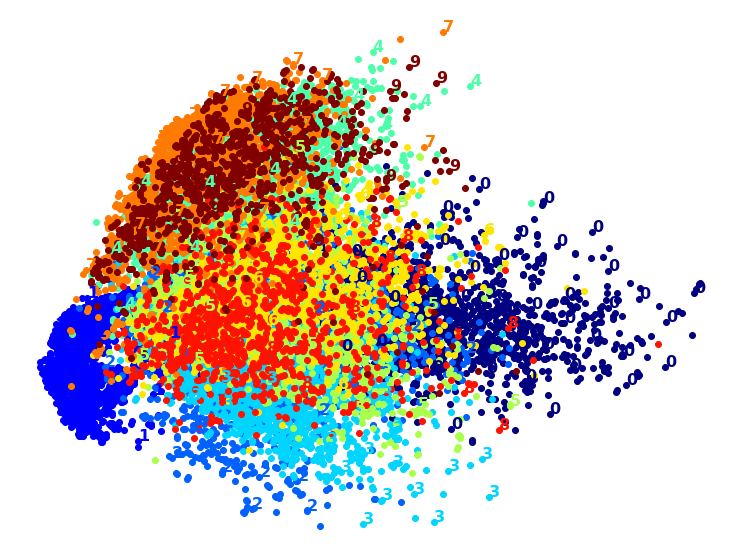

In [149]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42, init='pca',learning_rate='auto'))
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print(f"PCA+t-SNE took {t1 - t0:.1f}s.")
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!